In [26]:
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
from spectrum import Periodogram, parma, arma_estimate,  arma2psd,aryule, pyule
from pylab import log10, plot, xlabel, ylabel, axis
import pylab
import numpy as np
from scipy.fft import fft, fftfreq
from scipy import fftpack
import scipy as sp

In [2]:
lamda = 0.45
data = pd.read_csv("Data\lamda{}.csv".format(lamda))
data

,Step,AgentID,mi,mt
0,0,0,100.000,1.00000
1,0,1,100.000,1.00000
2,0,2,100.000,1.00000
3,0,3,100.000,1.00000
4,0,4,100.000,1.00000
...,...,...,...,...
3000495,6000,495,45.610,0.45610
3000496,6000,496,65.352,0.65352
3000497,6000,497,34.855,0.34855
3000498,6000,498,56.238,0.56238


In [3]:
agent = random.randint(0,499)
time = (data.loc[data['AgentID']==agent, 'Step'].reset_index(drop = True)).to_numpy()
money = (data.loc[data['AgentID']==agent, 'mi'].reset_index(drop = True)).to_numpy()

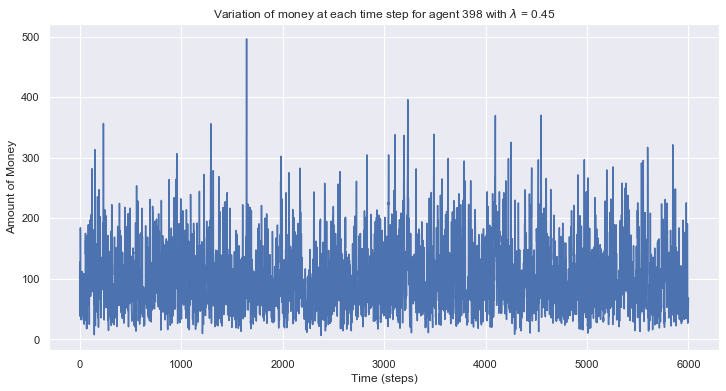

In [8]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(12,6)})
plt.plot(time,money)
plt.title("Variation of money at each time step for agent {} with $\lambda$ = {}".format(agent,lamda))
plt.xlabel("Time (steps)")
plt.ylabel("Amount of Money")
plt.savefig("TimeSeries_Lamda{}_Agent{}.png".format(lamda,agent))

<h3> Using Spectrum

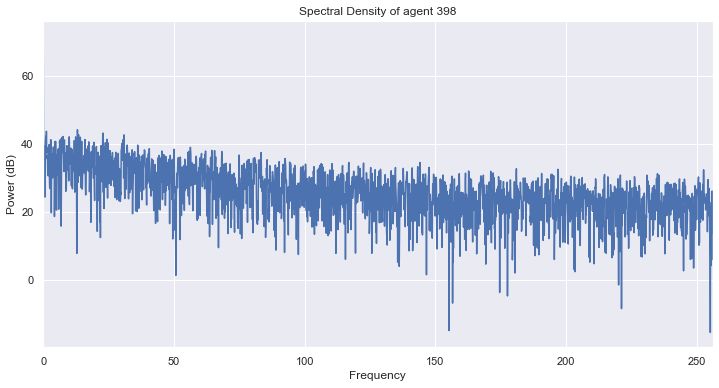

In [13]:
p = Periodogram(money, sampling=512)
p.run()
p.plot() 
plt.title("Spectral Density of agent {}".format(agent))
plt.savefig("Frequency_Agent{}".format(agent))

In [14]:
print(p)

Periodogram PSD estimate
    Data length is 6001
    PSD length is 3001
    Sampling 512
    freq resolution 0.08531911348108649
    datatype is real
    sides is onesided
    scal_by_freq is False



<h3> Auto Regressive Moving Model(ARMA)

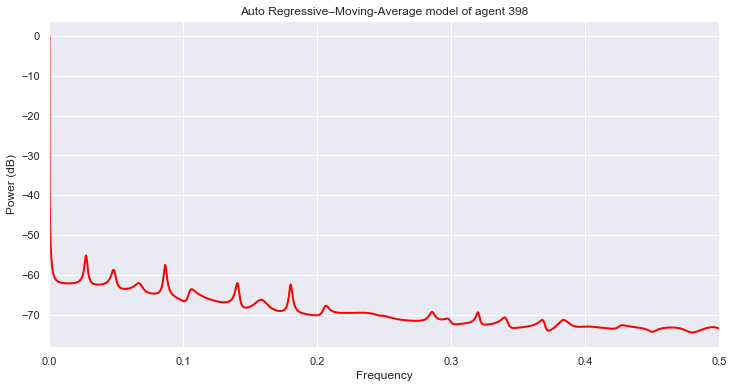

In [18]:
p = parma(money, 50, 50, 100, NFFT=len(money))
p.plot(norm=True, color='red', linewidth=2)
plt.title("Auto Regressive–Moving-Average model of agent {}".format(agent))
plt.savefig("ARMA_Agent{}".format(agent))

<h3> Power Spectral Density (PSD) from ARMA

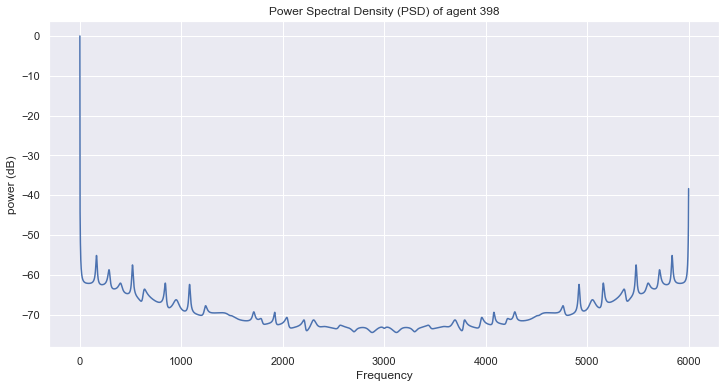

In [16]:
ar, ma, rho = arma_estimate(money, 50, 50, 100)
psd = arma2psd(ar, ma, rho=rho, NFFT=len(money))
plot(10*log10(psd/max(psd)))
xlabel('Frequency')
ylabel('power (dB)')
plt.title("Power Spectral Density (PSD) of agent {}".format(agent))
#axis([0, len(money), -50, 0])
plt.savefig("PSD_Agent{}".format(agent))

<h3> Yule Walker </h3>
<br>This method doesn't give satisfactory results even after changing the parameters multiple times.
(I am not sure if this method fits the context)

C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Evolution of the first AR parameters')

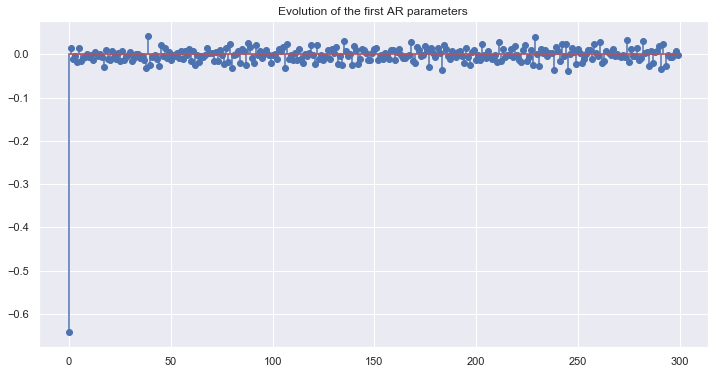

In [19]:
ar, variance, coeff_reflection = aryule(money, 300) #choosing order 15
#print(coeff_reflection)
pylab.stem(range(0,300), ar)
pylab.title('Evolution of the first AR parameters')

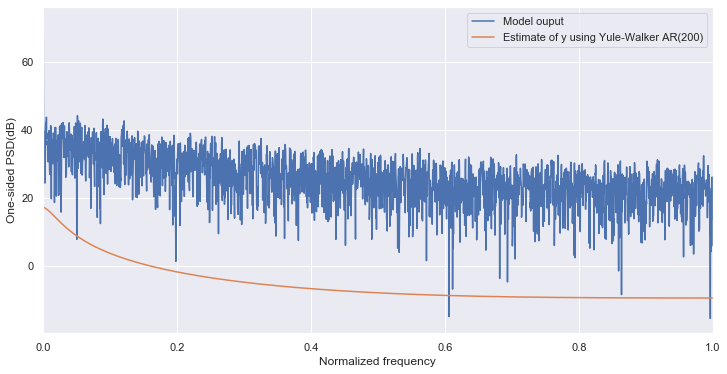

In [24]:
p = Periodogram(money, sampling=2)  #???
p.plot(label='Model ouput')

#estimate the original AR parameters
AR, P, k = aryule(money, 2) #???
PSD = arma2psd(AR, NFFT=500)
PSD = PSD[len(PSD):len(PSD)//2:-1]
x = np.linspace(0, 1, len(PSD))
plot(x, 10*log10(abs(PSD)*2./(2.*np.pi)),label='Estimate of y using Yule-Walker AR(200)')
xlabel(r'Normalized frequency')
ylabel('One-sided PSD(dB)')
plt.legend()

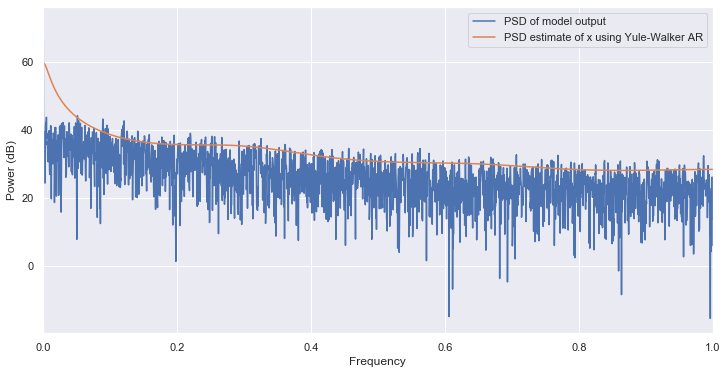

In [25]:
p = Periodogram(money, sampling=2)
p.plot(label = "PSD of model output")
p = pyule(money, 6, sampling=2, scale_by_freq=False)
p.plot(label = "PSD estimate of x using Yule-Walker AR")
plt.legend()

<h3> FFT using Scipy

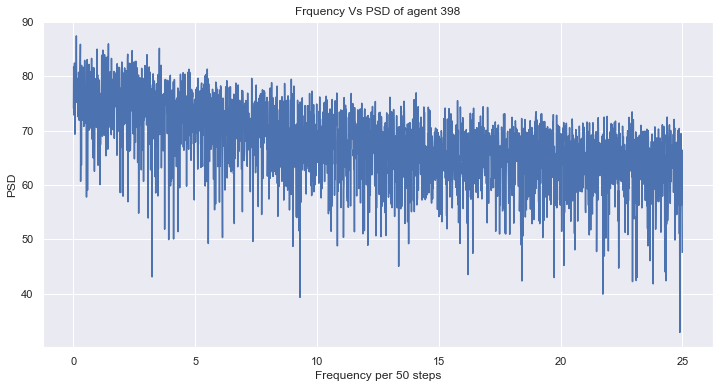

In [27]:
#Applying Fourier Transform
money_fft = sp.fftpack.fft(money)

#finding the power spectral density
money_psd = np.abs(money_fft) ** 2

#getting frequencies carresponding to each psd
fftfreq = sp.fftpack.fftfreq(len(money_psd), 1. / 50)
positive_freq = fftfreq > 0


#Plotting frequency domain against amplitude
#sns.set(rc={'figure.figsize':(10,6)})
sns.set_style("darkgrid")
plt.ylabel("PSD")
plt.xlabel("Frequency per 50 steps")
plt.plot(fftfreq[positive_freq],10 * np.log10(money_psd[positive_freq]))  
plt.title("Frquency Vs PSD of agent {}".format(agent))
plt.savefig("FrqPSD_Agent{}".format(agent))
plt.show()